In [8]:
%matplotlib inline 

from imports import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


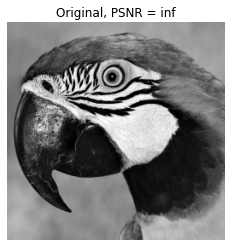

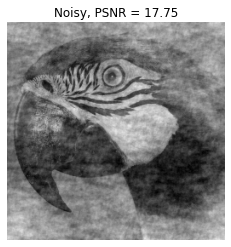

In [9]:
params = create_problem(img_path='./data/Set12/07.png')

psnr_display(img_path='./data/Set12/07.png', output=params['original'], title="Original")

psnr_display(img_path='./data/Set12/07.png', output=params['noisy'], title="Noisy")

### Denoising grayscale images with PnP-SVRG

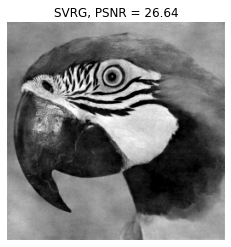

In [21]:
params = create_problem(img_path='./data/Set12/07.png', device=device, cnn_decay=0.90)

svrg_out, svrg_time, svrg_psnr, svrg_zs = pnp_svrg(params=params,
                                                   denoiser='cnn',
                                                   eta=20e3, tt=20, T2=10, 
                                                   mini_batch_size=int(20e3), verbose=False)

psnr_display(img_path='./data/Set12/07.png', output=svrg_out, title="SVRG")

In [ ]:
'''
Visualize GIF of denoising
'''

gif(svrg_zs)

### PnP-GD

In [23]:
params = create_problem('./data/Set12/07.png', device=device)

gd_out, gd_time, gd_psnr, gd_zs = pnp_gd(params=params,
                                         denoiser='cnn',
                                         eta=40e3, tt=20)

psnr_display(img_path='./data/Set12/07.png', output=gd_out, title="GD")

### PnP-SGD

In [15]:
params = create_problem('./data/Set12/07.png', device=device)

sgd_out, sgd_time, sgd_psnr, sgd_zs = pnp_sgd(params=params,
                                              denoiser='cnn',
                                              eta=20e3, tt=20, 
                                              mini_batch_size=int(20e3))

psnr_display(img_path='./data/Set12/07.png', output=sgd_out, title="SGD")

### PnP-LSVRG

In [16]:
params = create_problem('./data/Set12/07.png', device=device)

lsvrg_out, lsvrg_time, lsvrg_psnr, lsvrg_zs = pnp_lsvrg(params=params,
                                                denoiser='cnn',
                                                eta=20e3, tt=20, 
                                                mini_batch_size=int(20e3))

psnr_display(img_path='./data/Set12/07.png', output=lsvrg_out, title="LSVRG")

### Denoising RGB images with PnP-SVRG

In [17]:
original, noisy, denoised = denoise_rgb(img_path='./flickr30k/train/2594902417.jpg')

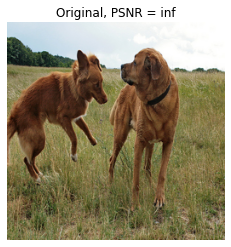

In [18]:
psnr_display(img=original, output=original, title="Original")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


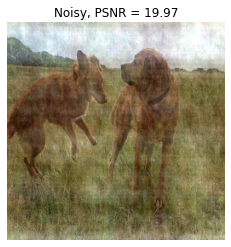

In [19]:
psnr_display(img=original, output=noisy, title="Noisy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


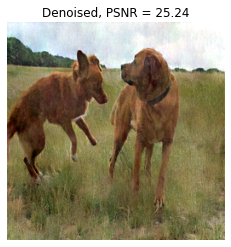

In [20]:
psnr_display(img=original, output=denoised, title="Denoised")